## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.v2 as transformsv2
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [32]:
size = 128

train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
train_transforms_extra = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor()
    ]
)
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64

trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
trainset_extra = Hotdog_NotHotdog(train=True, transform=train_transforms_extra)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
train_loader_extra = DataLoader(trainset_extra, batch_size=batch_size, shuffle=True)

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Let's look at some images from our data 

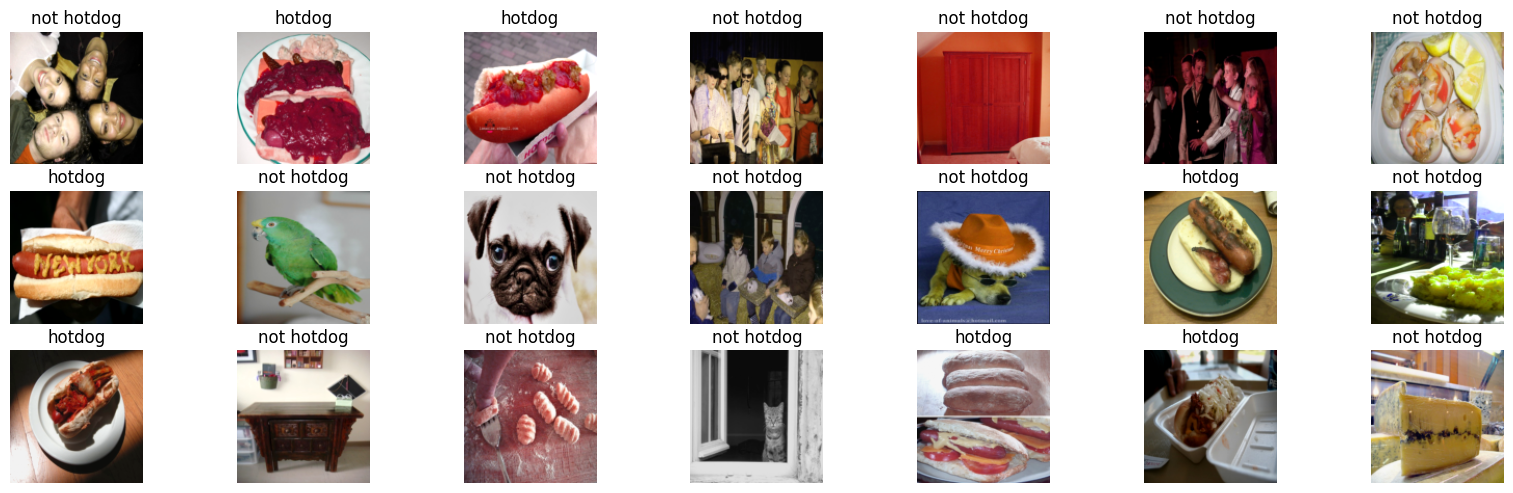

In [33]:
images, labels = next(iter(train_loader_extra))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [34]:
class HotNotDog(nn.Module):
    def __init__(self):
        super(HotNotDog, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.fully_connected = nn.Sequential(
                nn.Linear((size//2)**2*64, 1000),
                nn.ReLU(),
                nn.Linear(1000, 2),
                nn.Softmax(dim=1))
    
    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x
    
model = HotNotDog().to(device)
model.train()
# test

HotNotDog(
  (convolutional): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=262144, out_features=1000, bias=True)
 

In [35]:
from torchvision.models import resnet18, ResNet
from torchvision.models import ResNet18_Weights

resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

class LinearHead(nn.Module):
    def __init__(self, resnet_model: ResNet, out_features: int = 2):
        super(LinearHead, self).__init__()
        self.fc = nn.Linear(resnet_model.fc.out_features, out_features)
        self.softmax = nn.Softmax(dim=1)
        self.resnet_model = resnet_model
    
    def forward(self, x):
        x = self.resnet_model(x)
        x = self.fc(x)
        return x
    
model_resnet = LinearHead(resnet).to(device)

In [36]:
num_epochs = 20

optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

# Initialize lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Best accuracy tracking
best_test_acc = 0.0
best_model_path = "best_model.pth"

for epoch in tqdm(range(num_epochs), unit='epoch'):
    # Training phase
    model_resnet.train()
    train_correct = 0
    train_loss = 0.0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_resnet(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        # Track training loss and accuracy
        train_loss += loss.item()
        predicted = output.argmax(1)
        train_correct += (target == predicted).sum().cpu().item()

    # Compute average training loss and accuracy for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / len(trainset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Testing phase
    model_resnet.eval()
    test_correct = 0
    test_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_resnet(data)
            test_loss += F.cross_entropy(output, target).item()
            predicted = output.argmax(1)
            test_correct += (target == predicted).sum().cpu().item()
    
    # Compute average test loss and accuracy for the epoch
    avg_test_loss = test_loss / len(test_loader)
    test_acc = test_correct / len(testset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)
    
    # Save model if test accuracy improves
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model_resnet.state_dict(), best_model_path)
        print(f"New best test accuracy {100*test_acc:.1f}% at epoch {epoch+1}, model saved to {best_model_path}")

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

New best test accuracy 81.8% at epoch 1, model saved to best_model.pth


  0%|          | 0/32 [00:00<?, ?it/s]

New best test accuracy 84.6% at epoch 2, model saved to best_model.pth


  0%|          | 0/32 [00:00<?, ?it/s]

New best test accuracy 85.6% at epoch 3, model saved to best_model.pth


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

New best test accuracy 87.7% at epoch 8, model saved to best_model.pth


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

New best test accuracy 88.1% at epoch 12, model saved to best_model.pth


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [37]:
train_losses
test_losses
train_accuracies
test_accuracies

[0.817937701396348,
 0.8464017185821697,
 0.855531686358754,
 0.835123523093448,
 0.8544575725026853,
 0.8168635875402793,
 0.8378088077336198,
 0.8770139634801289,
 0.8603651987110634,
 0.7819548872180451,
 0.7556390977443609,
 0.8807733619763695,
 0.8480128893662728,
 0.8426423200859291,
 0.8625134264232008,
 0.8770139634801289,
 0.8711063372717508,
 0.8388829215896885,
 0.8576799140708915,
 0.8533834586466166]

In [ ]:
model_extra = HotNotDog().to(device)  # model trained with the extra data augmentation
model_extra.train()

optimizer = torch.optim.Adam(model_extra.parameters(), lr=0.001)

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    model_extra.train()
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader_extra), total=len(train_loader_extra)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model_extra(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    model_extra.eval()
    test_correct = 0
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model_extra(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 57.8%	 test: 62.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 71.3%	 test: 70.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 73.6%	 test: 71.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 75.2%	 test: 71.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 75.9%	 test: 71.8%
